In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import changepoint as chp
#import re
import math
#plt.xkcd()
import numpy as np
%matplotlib inline

In [2]:
#Importing lists of users and contacts
users = pd.read_table('/home/pavel-s/users_usa.csv',sep=',',names = ('Node','Time','Name','City','Country','Code1','Code2','Code3'),error_bad_lines=False)
contacts = pd.read_table('contacts.txt',sep=' ',names=('Node1','Node2','Time'),error_bad_lines=False)
#Creating new table with USA-citizens
users_usa = users[users['Country']==str('USA')]
contacts_usa = contacts[(contacts['Node1'].isin(users_usa['Node'])) & (contacts['Node2'].isin(users_usa['Node']))]

/home/pavel-s/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Deleting negative time
contacts_usa = contacts_usa[contacts_usa['Time']>0]
users_usa = users_usa[users_usa['Time']>0]
contacts_usa[contacts_usa['Time']<0]

,Node1,Node2,Time


In [73]:
#Замена данных COUNTRY на USA:
for i in range(0,len(users['Node'])-1):
    if 'us' in str(users['Country'].iloc[[i]].values[0]).lower() or 'usa' in str(users['Country'].iloc[[i]].values[0]).lower()or 'u.s.a' in str(users['Country'].iloc[[i]].values[0]).lower()or 'united' in str(users['Country'].iloc[[i]].values[0]).lower() or 'states' in str(users['Country'].iloc[[i]].values[0]).lower() or 'america' in str(users['Country'].iloc[[i]].values[0]).lower() or 'u s a' in str(users['Country'].iloc[[i]].values[0]).lower():
        users['Country'].iloc[[i]] = str('USA')
users.head(15)

/home/pavel-s/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Node,Time,Name,City,Country,Code1,Code2,Code3
0,41,6185144,Eric,Astoria NY,USA,LGA,14,21/32684967_34a634c3f9
1,42,6185144,Jason Classon,Vancouver,Canada,YVR,5,1/1233818_76bf2d829a
2,44,6185144,neb,san francisco,USA,sfo,5,1/725198_1c03b8c0d4
3,46,6185144,Stewart,San Francisco,USA,SFO,5,3/4630588_2846483590
4,48,6185144,joly & TESTING,NaN,NaN,NaN,14,1/101_1c2df3d710
5,49,6185144,Grandpa,NaN,NaN,NaN,0,NaN
6,51,6185144,ericost,NaN,NaN,NaN,0,1/147_ad7d9acfc4
7,52,6185144,Ignore Eric Testing,NaN,NaN,NaN,0,1/416_2ceab47173
8,53,6185144,joly moly,NaN,NaN,NaN,0,1/615_11cf532958
9,56,6185144,chinook,NaN,NaN,NaN,5,4/4068106_5afc34fb20


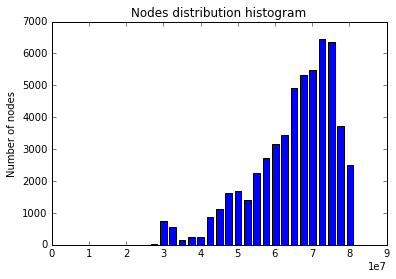

In [183]:
#Гистограмма распределения количества связей во времени
fig = plt.figure()
ax1 = fig.add_subplot (1,1,1)
hist, bins = np.histogram(users_usa['Time'], bins=30)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
ax1.set_ylabel('Number of nodes')
ax1.set_title ('Nodes distribution histogram')
plt.bar(center, hist, align='center', width=width)
plt.show()

In [4]:
#Разбивка исходной таблицы USERS и CONTACTS на несколько подтаблиц с разным временем
new_users = users_usa.sort('Time')
index1 = pd.Series(range(0,len(new_users['Node'])))
new_users = new_users.set_index(index1)
data_users = [new_users.head(i*1000) for i in range(1,54)]
new_contacts = contacts_usa.sort('Time')
index2 = pd.Series(range(0,len(new_contacts['Node1'])))
new_contacts = new_contacts.set_index(index2)
data_contacts = [new_contacts[new_contacts['Time']<=int(data_users[i]['Time'].iloc[[-1]])] for i in range(0,53)]

/home/pavel-s/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
/home/pavel-s/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [5]:
#Создание пустых графов
graph=[nx.Graph() for i in range(0,53)]

In [42]:
%%time
##CREATING GRAPHS##
for num in range(13,20):
#Добавление узлов в граф
    graph[num].add_nodes_from([(int(data_users[num]['Node'].iloc[[i]]),
                              {'Time':int(data_users[num]['Time'].iloc[[i]]),
                               'Name':data_users[num]['Name'].iloc[[i]].values[0],
                               'City':data_users[num]['City'].iloc[[i]].values[0],
                               'Country':data_users[num]['Country'].iloc[[i]].values[0]}) for i in range(0,len(data_users[num]['Node']))])
#Добавление связей в граф
    graph[num].add_edges_from([(int(data_contacts[num]['Node1'].iloc[[i]]),
                              int(data_contacts[num]['Node2'].iloc[[i]])) for i in range(0,len(data_contacts[num]['Node1']))])

CPU times: user 6min 50s, sys: 4.4 s, total: 6min 54s
Wall time: 6min 51s


In [28]:
#Detecting Giant Connected Component for SI#
len(sorted(nx.connected_components(graph[4]), key = len, reverse=True)[0])/nx.number_of_nodes(graph[4])

0.2966

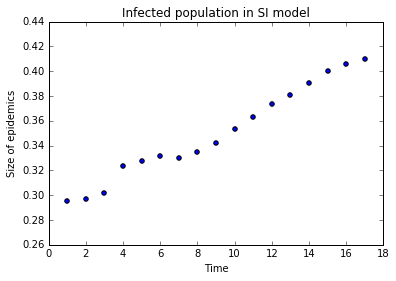

In [180]:
#Plot 'Time' - 'Infected population in SI model'
fig = plt.figure()
ax1 = fig.add_subplot (1,1,1)
#plt.xlim([0, 0.006])
ax1.set_xlabel('Time')
ax1.set_ylabel('Size of epidemics')
ax1.set_title ('Infected population in SI model')
scatter(range(1,18),list(map(operator.truediv,nodes_in_component,nodes_in_graph)))
show()

In [43]:
%%time
#####Percolation#####
from random import *
from pylab import hist, scatter, show, plot

#Define parameters
t_values = [i/20 for i in range(21)]
number_values = range(13,20)
#number = 4 #number of graph in list
#T = 0.25 #probability of transmission
initial = 1 #number of initially infected nodes

#Empty lists for time series of graphs
#ts_epi_size = []
#ts_betw_corr = []
#ts_close_corr = []
#ts_degree_corr = []
#ts_density = []

#Loop for graphs' evolution
for number in number_values:

    #Construct network
    net_size = graph[number].order()
    mean_epi_sizes = []
    betw_corr = []
    close_corr = []
    degree_corr = []
    #In order to get maximum spread of infection we should start contagion from node in Giant component
    nodes = list(sorted(nx.connected_components(graph[number]), key = len, reverse=True)[0])
    G = graph[number].subgraph(nodes)

    #Compute measures of centrality
    betw_perc = nx.betweenness_centrality(graph[number],normalized = True)
    degree_perc = nx.degree_centrality(graph[number]) 

    for T in t_values:
        results = []
        node_betw_centr = []
        node_close_centr = []
        node_degree_centr = []
        for i in range(100):
        #Store node states
            first = sample(G.nodes(),initial)
            node_betw_centr.append(betw_perc.get(first[0])) #only for case of initial = 1
            node_close_centr.append(nx.closeness_centrality(graph[number],first[0],normalized = True))  #only for case of initial = 1
            node_degree_centr.append(degree_perc.get(first[0]))  #only for case of initial = 1
            infected = first # Randomly choose one node
            recovered = []

        #Run the simulation
            while len(infected) > 0:
                v = infected.pop(0)
                for u in graph[number].neighbors(v):
                    # We need to make sure Node u is still susceptible
                    if u not in infected and u not in recovered:
                        if random() < T:
                            infected.append(u)
                recovered.append(v)

        #Tally the total fraction that got infected
            epi_size = len(recovered)/net_size
            results.append(epi_size)
        mean_epi_sizes.append(np.mean(results))
        betw_corr.append(np.corrcoef(node_betw_centr, results)[0][1])
        close_corr.append(np.corrcoef(node_close_centr, results)[0][1])
        degree_corr.append(np.corrcoef(node_degree_centr, results)[0][1])
    ts_epi_size.append(np.mean(mean_epi_sizes))
    ts_betw_corr.append(np.mean(betw_corr))
    ts_close_corr.append(np.mean(close_corr))
    ts_degree_corr.append(np.mean(degree_corr))
    ts_density.append(nx.density(graph[number]))

'''Plot "Epidemics mean size histogram"
fig = plt.figure()
ax1 = fig.add_subplot (1,1,1)
#ax1.set_ylabel('T, threshold of infection')
ax1.set_xlabel('Mean size of epidemics')
ax1.set_title ('Epidemics mean size histogram (initially infected = 50)')
hist(results, bins = 30)
plt.legend(['T=0.25'],loc = 'upper left')
show()
#print(np.mean(results))'''

CPU times: user 10h 48min 1s, sys: 4.36 s, total: 10h 48min 5s
Wall time: 10h 47min 40s


In [139]:
#Analysis of Giant Connected Component, density etc.
import operator
nodes_in_component = []
nodes_in_graph = []
other_nodes = []
edges_in_component = []
edges_in_graph = []
other_edges = []
density_component = []
periods = range(1,17)
#Counting increment of added nodes and edges
for i in range(3,20):
    nodes_in_component.append(len(list(sorted(nx.connected_components(graph[i]), key = len, reverse=True)[0])))
    nodes_in_graph.append(nx.number_of_nodes(graph[i]))
    other_nodes.append(nodes_in_graph[i-3] - nodes_in_component[i-3])
    edges_in_component.append(nx.number_of_edges(graph[i].subgraph(list(sorted(nx.connected_components(graph[i]), key = len, reverse=True)[0]))))
    edges_in_graph.append(nx.number_of_edges(graph[i]))
    other_edges.append(edges_in_graph[i-3] - edges_in_component[i-3])
    pos_edges_graph = [i*(i-1)/2 for i in nodes_in_graph]
    pos_edges_component = [i*(i-1)/2 for i in nodes_in_component]
    pos_edges_others = [i*(i-1)/2 for i in other_nodes]
    density_component.append(nx.density(graph[i].subgraph(list(sorted(nx.connected_components(graph[i]), key = len, reverse=True)[0]))))

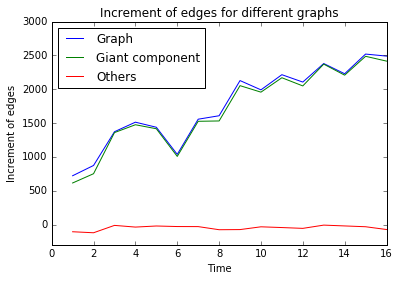

In [128]:
#Increment of edges in time
from pylab import plot
fig = plt.figure()
ax1 = fig.add_subplot (1,1,1)
plt.ylim([-300, 3000])
ax1.set_xlabel('Time')
ax1.set_ylabel('Increment of edges')
ax1.set_title ('Increment of edges for different graphs')
plot(periods,list(map(operator.sub, edges_in_graph[1:], edges_in_graph[:-1])))
plot(periods,list(map(operator.sub, edges_in_component[1:], edges_in_component[:-1])))
plot(periods,list(map(operator.sub, other_edges[:-1], other_edges[1:])))
plt.legend(['Graph','Giant component','Others'], loc = 'upper left')
show()

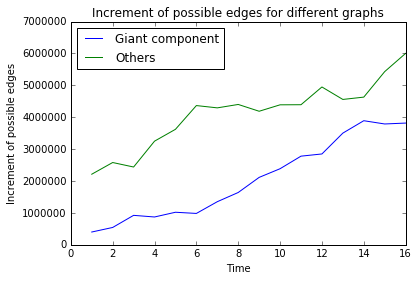

In [138]:
#Increment of possible edges in time
from pylab import plot
fig = plt.figure()
ax1 = fig.add_subplot (1,1,1)
#plt.ylim([200, 1000])
ax1.set_xlabel('Time')
ax1.set_ylabel('Increment of possible edges')
ax1.set_title ('Increment of possible edges for different graphs')
#plot(periods,list(map(operator.sub, pos_edges_graph[1:], pos_edges_graph[:-1])))
plot(periods,list(map(operator.sub, pos_edges_component[1:], pos_edges_component[:-1])))
plot(periods,list(map(operator.sub, pos_edges_others[1:], pos_edges_others[:-1])))
plt.legend(['Giant component','Others'], loc = 'upper left')
show()

In [164]:
len(density_component)

17

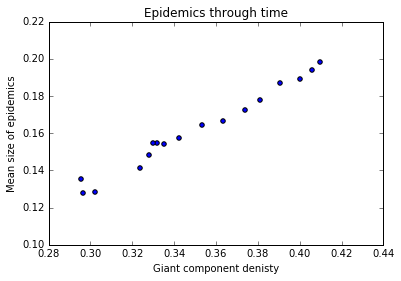

In [152]:
#Plot 'Mean size of epidemics' - 'Giant component density'
fig = plt.figure()
ax1 = fig.add_subplot (1,1,1)
#plt.xlim([0, 0.006])
ax1.set_xlabel('Giant component denisty')
ax1.set_ylabel('Mean size of epidemics')
ax1.set_title ('Epidemics through time')
scatter(list(map(operator.truediv,nodes_in_component,nodes_in_graph)), ts_epi_size)
show()

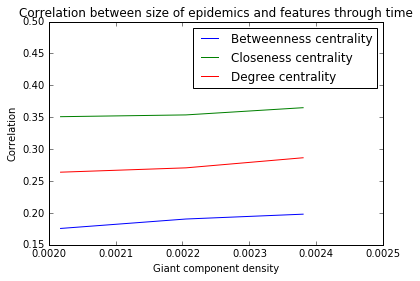

In [177]:
#Plot 'Average correlation between size of epidemics and features through time'
from pylab import plot
fig = plt.figure()
ax1 = fig.add_subplot (1,1,1)
plt.xlim([0.002, 0.0025])
plt.ylim([0.15, 0.5])
ax1.set_xlabel('Giant component density')
ax1.set_ylabel('Correlation')
ax1.set_title ('Correlation between size of epidemics and features through time')
plot(density_component,ts_betw_corr)
plot(density_component,ts_close_corr)
plot(density_component,ts_degree_corr)
plt.legend(['Betweenness centrality','Closeness centrality','Degree centrality'], loc = 'upper right')
show()

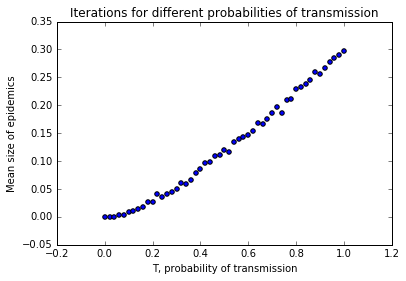

In [171]:
#Plot 'Mean size of epidemics' - 'T'
fig = plt.figure()
ax1 = fig.add_subplot (1,1,1)
ax1.set_xlabel('T, probability of transmission')
ax1.set_ylabel('Mean size of epidemics')
ax1.set_title ('Iterations for different probabilities of transmission')
scatter(t_values, mean_epi_sizes)
show()

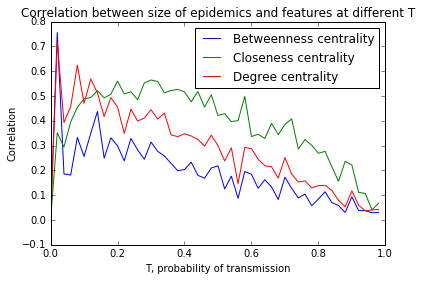

In [172]:
#Plot 'Correlation between size of epidemics and features at different T'
from pylab import plot
fig = plt.figure()
ax1 = fig.add_subplot (1,1,1)
ax1.set_xlabel('T, probability of transmission')
ax1.set_ylabel('Correlation')
ax1.set_title ('Correlation between size of epidemics and features at different T')
plot(t_values,betw_corr)
plot(t_values,close_corr)
plot(t_values,degree_corr)
plt.legend(['Betweenness centrality','Closeness centrality','Degree centrality'], loc = 'upper right')
show()

In [151]:
#Compute correlations between size of epidemics and features
print('Correlation "Betweenness centrality - Size of epidemics":', np.corrcoef(node_betw_centr, results)[0][1])
print('Correlation "Closeness centrality - Size of epidemics":',np.corrcoef(node_close_centr, results)[0][1])
print('Correlation "Degree centrality - Size of epidemics":',np.corrcoef(node_degree_centr, results)[0][1])

Correlation "Betweenness centrality - Size of epidemics": 0.126539071842
Correlation "Closeness centrality - Size of epidemics": 0.400042974606
Correlation "Degree centrality - Size of epidemics": 0.236422456367


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.2 µs


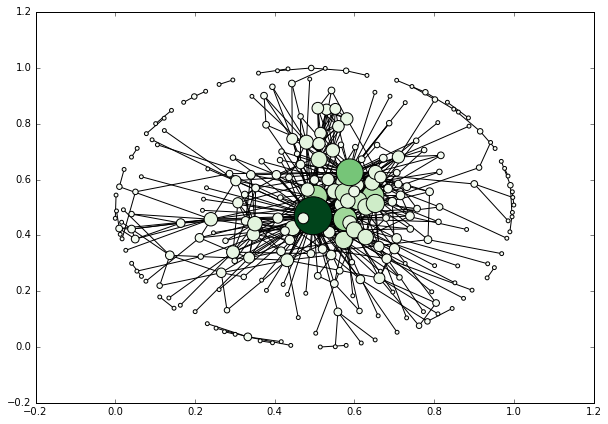

In [204]:
#Plotting graph with node size depending on degree
G=nx.from_pandas_dataframe(contacts_usa[contacts_usa['Time']<30000000], 'Node1', 'Node2')
#G=graph[6].subgraph(list(sorted(nx.connected_components(graph[6]), key = len, reverse=True)[0]))
k = nx.degree(G)
plt.figure(1, figsize=(10,7))
coord = nx.spring_layout(G)
%time
nx.draw_networkx(G,
                 pos=coord,
                 with_labels=0,
                 nodelist=k.keys(),
                 node_size = [d*15 for d in k.values()],
                 font_size=10,
                 node_color=list(k.values()),
                 cmap=plt.cm.Greens,
                 )

In [7]:
#Creating list of empty DataFrames for TRAIN
train = [pd.DataFrame() for i in range(0,53)]
pretrain = [pd.DataFrame() for i in range(0,53)]

In [11]:
len(data_contacts[3])

6437

In [104]:
%%time
#Creating design matrix
import itertools
from itertools import combinations
from random import *
r=2
num=9
for_design = sample(data_users[num-2]['Node'].tolist(),100)
com = list(combinations(for_design, r))
pretrain[num]=pd.DataFrame(com, columns = ['Node1','Node2'])
train[num] = pd.concat([pretrain[num],data_contacts[num-2][['Node1','Node2']].sample(6000)])
train[num].drop_duplicates()
index = pd.Series(range(0,len(train[num]['Node1'])))
train[num] = train[num].set_index(index)

CPU times: user 24 ms, sys: 8 ms, total: 32 ms
Wall time: 126 ms


In [105]:
%%time
#Calculating predictors and writing to data frame
num=9
unique_betw = nx.betweenness_centrality(graph[num-1],normalized = True)
closeness = sum(nx.closeness_centrality(graph[num-1],normalized = True).values())/nx.number_of_nodes(graph[num-1])
betweenness = sum(unique_betw.values())/nx.number_of_nodes(graph[num-1])
density = nx.density(graph[num-1])
degree = nx.degree_centrality(graph[num-1])
for i in range(0,len(train[num]['Node1'])):
    source = train[num]['Node1'][i]
    target = train[num]['Node2'][i]
    try:
        train[num].loc[i,'Shortest_path'] = len(nx.shortest_path(graph[num-1],source,target))-1
    except nx.NetworkXNoPath:
        train[num].loc[i,'Shortest_path'] = 15000
    train[num].loc[i,'Jaccard'] = next(nx.jaccard_coefficient(graph[num-1],((source,target),)))[2]
    train[num].loc[i,'delta Jaccard'] = train[num].loc[i,'Jaccard']-next(nx.jaccard_coefficient(graph[num-2],((source,target),)))[2]
    train[num].loc[i,'Cluster coef'] = sum(nx.clustering(graph[num-1],[source,target]).values())
    train[num].loc[i,'delta Cluster coef'] = train[num].loc[i,'Cluster coef']-sum(nx.clustering(graph[num-2],[source,target]).values())
    train[num].loc[i,'Degree centr'] = degree.get(source)+degree.get(target)
    train[num].loc[i,'AvClose'] = closeness
    train[num].loc[i,'AvBetw'] = betweenness
    train[num].loc[i,'Close'] = nx.closeness_centrality(graph[num-1],source,normalized = True)+nx.closeness_centrality(graph[num-1],target,normalized = True)
    train[num].loc[i,'Betw'] = unique_betw.get(source)+unique_betw.get(target)
    train[num].loc[i,'Density'] = density
    if len(data_contacts[num][(data_contacts[num]['Node1'].values==source) & (data_contacts[num]['Node2'].values==target)])==1 or len(data_contacts[num][(data_contacts[num]['Node1'].values==target) & (data_contacts[num]['Node2'].values==source)])==1:
        train[num].loc[i,'Link']=1
    else:
        train[num].loc[i,'Link']=0

CPU times: user 7min 5s, sys: 12 ms, total: 7min 5s
Wall time: 7min 5s


In [8]:
#Import TRAIN
train_set = pd.read_csv('/home/pavel-s/train5.csv',sep=',',names = ['Node1','Node2','Shortest_path','Close','Betw','Jaccard','delta Jaccard','Cluster coef','delta Cluster coef','Degree centr','AvClose','AvBetw','Density','Link'],error_bad_lines=False)
train_set = train_set[1:]
index = pd.Series(range(0,len(train_set['Link'])))
train_set = train_set.set_index(index)

In [11]:
#Import TEST
test_set = pd.read_csv('/home/pavel-s/train9.csv',sep=',',names = ['Node1','Node2','Shortest_path','Close','Betw','Jaccard','delta Jaccard','Cluster coef','delta Cluster coef','Degree centr','AvClose','AvBetw','Density','Link'],error_bad_lines=False)
test_set = test_set[1:]
index = pd.Series(range(0,len(test_set['Link'])))
test_set = test_set.set_index(index)

In [12]:
#Concatenate Data Frames
train_set = pd.concat([train_set,test_set])
index = pd.Series(range(0,len(train_set['Link'])))
train_set = train_set.set_index(index)

In [187]:
train_set[['AvClose','AvBetw','Cluster coef','Jaccard','Link']].sample(10)

,AvClose,AvBetw,Cluster coef,Jaccard,Link
14462,0.21083401955582676,0.02448830043477378,0.04560912182436487,0.15617938997637132,1
21675,0.00022225926543312772,0.0,0.0001666944490748458,0.0,0
18477,0.05797216599970348,0.0,0.0001666944490748458,0.0,0
13170,0.12629614869154945,2.6174432724410186e-07,0.0054010802160432084,1.7833333333333332,1
31537,0.00029632922176538136,7.409877183508647e-08,0.00022224691632403602,0.0,0
8750,0.05096307511125238,0.0,0.00040008001600320064,1.0,0
4634,0.1347643754303316,1.6009604481920797e-08,0.0014002800560112022,0.9333333333333333,0
12778,0.18728900295985224,0.0015675081268454614,0.013602720544108823,0.8284690799396681,1
3705,0.06920029461869692,8.531891251176281e-06,0.000600120024004801,0.3333333333333333,0
27343,0.14751230434319057,0.00021248551321179467,0.0016669444907484582,0.2777777777777778,1


In [23]:
#Link into 'str' for Random Forest creation
for i in range(0,len(train_set)):
        train_set['Link'][i] = str(train_set['Link'][i])

In [14]:
%%time
#Random Forest Classification
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import KFold
from sklearn import grid_search
from sklearn import preprocessing
X = train_set[['Close','Betw','Jaccard','delta Jaccard','Cluster coef','delta Cluster coef','Degree centr','AvClose','AvBetw','Density']]
y = train_set[['Link']]
lb = preprocessing.LabelBinarizer()
lb.fit(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
#grid = {'n_estimators':np.arange(100,1000,100),'max_features': np.arange(1, len(X.columns), 1)}
#cv = KFold(y_train.size, n_folds=5, shuffle=True, random_state=1580)
#Creating forest (fitting parametrs)
forest = RandomForestClassifier(n_estimators=300,max_features = 3,random_state=1580, criterion='gini',oob_score = True)
#gs = grid_search.GridSearchCV(clf, grid, cv=cv, n_jobs=4)
forest.fit(X_train, y_train)
#forest = gs.best_estimator_ #получили оптимальную модель

CPU times: user 10.2 s, sys: 88 ms, total: 10.3 s
Wall time: 11.4 s


/home/pavel-s/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [181]:
train_set.to_csv('/home/pavel-s/train_set.csv',sep=',',header=True)

In [110]:
print(gs.best_params_)

{'n_estimators': 100, 'max_features': 3}


Confusion matrix
[[6135  152]
 [  29 5406]]


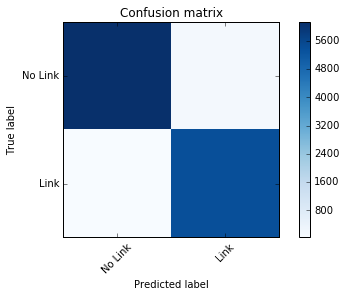

In [15]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = forest.predict(X_test)

#Define function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Link','Link'], rotation=45)
    plt.yticks(tick_marks, ['No Link','Link'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm)
plt.show()

In [16]:
#Calculate metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
print('Accuracy (test): ', accuracy_score(y_test, y_pred))
print('Recall (test): ', cm[1][1]/(cm[1][1]+cm[0][1]))
print('Precision (test): ', cm[1][1]/(cm[1][1]+cm[1][0]))

Accuracy (test):  0.984558948985
Recall (test):  0.972652033105
Precision (test):  0.994664213431


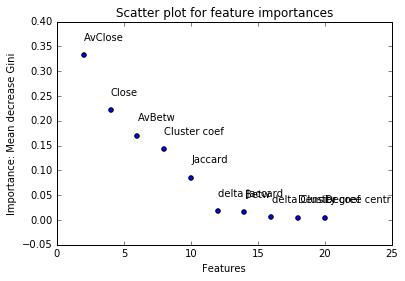

In [98]:
#Features importance
from pylab import hist, scatter, show, plot
names = ['Close','Betw','Jaccard','delta Jaccard','Cluster coef','delta Cluster coef','Degree centr','AvClose','AvBetw','Density']
importances = sorted(zip(map(lambda x: round(x, 4), forest.feature_importances_), names), reverse=True)
#print(importances)
#print(forest.feature_importances_)
x = [4,14,10,12,8,16,20,2,6,18]
fig = plt.figure()
ax1 = fig.add_subplot (1,1,1)
ax1.set_xlabel('Features')
ax1.set_ylabel('Importance: Mean decrease Gini')
ax1.set_title ('Scatter plot for feature importances')
for i in range(0,10):
    ax1.annotate(names[i], xy = (x[i], forest.feature_importances_[i]),xytext=(x[i]+0.03, forest.feature_importances_[i]+0.03))
scatter(x, forest.feature_importances_)
show()

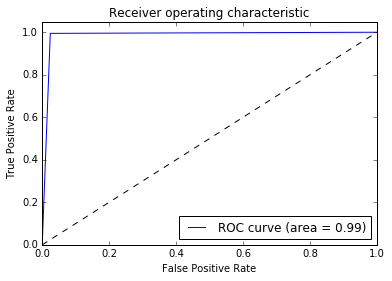

In [28]:
#ROC-AUC
from sklearn.metrics import roc_curve, auc
y_score = forest.predict(X_test)
index = pd.Series(range(0,len(y_test['Link'])))
y_test = y_test.set_index(index)
for i in range(0,len(y_test)):
        y_test['Link'][i] = int(float(y_test['Link'][i]))
y_test_roc = [int(x) for x in list(y_test['Link'])]
y_score_roc = [int(float(x)) for x in y_score]
fpr, tpr, _ = roc_curve(y_test_roc, y_score_roc)
roc_auc = auc(fpr, tpr)
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()